# CMPUT 328 — Linear & Multiple Regression on MNIST (Colab)

**Instructor:** Nilanjan Ray, University of Alberta  
**Lecture:** Linear, Multiple, and Logistic Regressions (3 hours)  
**Notebook goal:** Hands‑on companion aligned with the lecture slides *LinearRegression.pptx*

---

### How to use this notebook
- Run the **Setup** first.
- Each section mirrors the slides:
  1. Linear Regression — **Direct (closed‑form)**
  2. Linear Regression — **PyTorch Optimization**
  3. Multiple Linear Regression — **Direct (closed‑form)**
  4. Multiple Linear Regression — **PyTorch Optimization**
- Optional stretch: implement **Logistic Regression (Softmax + Cross‑Entropy)** as an exercise at the end.

> Tip: In Colab, enable *View → Table of contents*.

## 🔧 Setup

This cell installs/imports dependencies and sets deterministic seeds.  
Run this **once at the beginning**.

In [1]:
# If running in Google Colab, uncomment the installs below.
# !pip install -q torch torchvision torchaudio

import os, math, random, numpy as np
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import torchvision

# Reproducibility
torch.manual_seed(0)
np.random.seed(0)
random.seed(0)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

# 1) Linear Regression — Direct (closed‑form)

**Slides:** Linear prediction, loss, centering, ridge, normal equations; Toy example.

> Below are the original cells from `MNIST_Linear_Regression_Direct.ipynb`.


# Linear Regression for MNIST Images
## This notebook uses closed form (aka direct) solution

In [2]:
import torch

random_seed = 1
torch.backends.cudnn.enabled = False
torch.manual_seed(random_seed)

# Checking GPU availability
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)


cuda:0


# MNIST dataset is part of torchvision
## Divide MNIST into training, validation and test sets
## Use DataLoader iterator for loading data in batches

In [3]:
from torch.utils.data import random_split


MNIST_training = torchvision.datasets.MNIST('/MNIST_dataset/', train=True, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize((0.1307,), (0.3081,))]))

MNIST_test_set = torchvision.datasets.MNIST('/MNIST_dataset/', train=False, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize((0.1307,), (0.3081,))]))

# create a training and a validation set
MNIST_training_set, MNIST_validation_set = random_split(MNIST_training, [55000, 5000])


train_loader = torch.utils.data.DataLoader(MNIST_training_set,batch_size=55000, shuffle=True)

validation_loader = torch.utils.data.DataLoader(MNIST_validation_set,batch_size=5000, shuffle=True)

test_loader = torch.utils.data.DataLoader(MNIST_test_set,batch_size=10000, shuffle=True)

100%|██████████| 9.91M/9.91M [00:02<00:00, 4.58MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 133kB/s]
100%|██████████| 1.65M/1.65M [00:01<00:00, 1.26MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 7.90MB/s]


## Check DataLoader

In [4]:
examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)
print(example_data.shape)
print(example_targets.shape)

torch.Size([10000, 1, 28, 28])
torch.Size([10000])


## Also, make sure to display some images

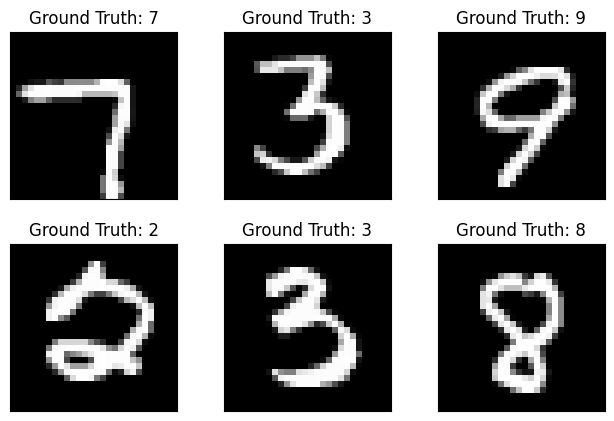

In [5]:
import matplotlib.pyplot as plt

fig = plt.figure()
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
  plt.title("Ground Truth: {}".format(example_targets[i]))
  plt.xticks([])
  plt.yticks([])

## Use closed form (aka direct) solution for $\theta$, $mean$ and $b$

In [6]:
def Estimate_Parameters(train_X,train_y,lam):
  # flatten data
  train_X = train_X.view(train_X.size(0), -1)
  train_y = train_y.float()


  # compute b
  b = torch.mean(train_y)
  # compute mean
  train_X_mean = torch.mean(train_X,dim=0,keepdim=True)
  # compute theta
  X = train_X - train_X_mean
  theta = torch.mm(torch.mm(torch.inverse(torch.matmul(X.t(),X)+lam*torch.eye(784)),X.t()),(train_y-b).view(train_X.size(0),1))

  return theta,train_X_mean,b


## Prediction on validation or test data with leanred model

In [7]:
def Model_Predict(X,theta,data_mean,b): # Notice prediction does not require *lam*
  X = X.view(X.size(0), -1)
  yp = torch.mm(X - data_mean, theta) + b
  return yp

## Accuracy computation

In [8]:
def Compute_Accuracy(yp,y):
  classes = torch.tensor([0,1,2,3,4,5,6,7,8,9]).view(1,10).float()
  _, pred = torch.min(torch.abs(yp - classes),dim=1)

  accuracy = (100. * pred.eq(y.data.view_as(pred)).sum()) / y.shape[0]
  return accuracy

## Estimating parameters of the model on training data

In [9]:
def Model_Train(lam):
  train_examples = enumerate(train_loader)
  batch_idx, (train_X, train_y) = next(train_examples)
  theta,data_mean,b = Estimate_Parameters(train_X,train_y,lam)
  return theta,data_mean,b

## Apply model on validation or test and evaluate accuracy

In [10]:
def Model_Evaluate(data_loader,theta,data_mean,b):
  # load  data
  examples = enumerate(data_loader)
  batch_idx, (X, y) = next(examples)

  # compute prediction
  yp = Model_Predict(X,theta,data_mean,b)

# compute accuracy
  accuracy = Compute_Accuracy(yp,y)
  return accuracy

In [11]:
# Apply linear model on the validation and test sets
lam=0.1 # this is only a guess value. It needs to be estimated using the validation set.
theta,data_mean,b = Model_Train(lam)

validation_accuracy = Model_Evaluate(validation_loader,theta,data_mean,b)
print("Validation set accuracy:", validation_accuracy.item())

test_accuracy = Model_Evaluate(test_loader,theta,data_mean,b)
print("Test set accuracy:", test_accuracy.item())


Validation set accuracy: 23.200000762939453
Test set accuracy: 23.020000457763672


## Using validation set estimate best hyperparameter value

### This is known as grid search method

In [12]:
import numpy as np

best_accuracy = 0.0
best_lam = 0.0
for i in torch.range(-1,6,1):
  lam = np.power(10,i)
  theta, data_mean,b = Model_Train(lam)
  validation_accuracy = Model_Evaluate(validation_loader,theta, data_mean,b)
  print("Hyperparameter value:",lam.item()," Validation set accuracy:", validation_accuracy.item())
  if validation_accuracy>best_accuracy:
    best_lam = lam
    best_accuracy = validation_accuracy

# best hyperparameter
print("Best hyperparameter value:",best_lam.item())
# estimate model with best hyperparameter value
best_theta, best_data_mean,best_b = Model_Train(best_lam)

# apply best model on test set
test_accuracy = Model_Evaluate(test_loader,best_theta, best_data_mean,best_b)
print("Test set accuracy:", test_accuracy.item())

/tmp/ipython-input-3915154501.py:5: UserWarning: torch.range is deprecated and will be removed in a future release because its behavior is inconsistent with Python's range builtin. Instead, use torch.arange, which produces values in [start, end).
  for i in torch.range(-1,6,1):
/tmp/ipython-input-3915154501.py:6: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  lam = np.power(10,i)


Hyperparameter value: 0.10000000149011612  Validation set accuracy: 23.18000030517578
Hyperparameter value: 1.0  Validation set accuracy: 23.200000762939453
Hyperparameter value: 10.0  Validation set accuracy: 23.280000686645508
Hyperparameter value: 100.0  Validation set accuracy: 23.459999084472656
Hyperparameter value: 1000.0  Validation set accuracy: 23.020000457763672
Hyperparameter value: 10000.0  Validation set accuracy: 22.020000457763672
Hyperparameter value: 100000.0  Validation set accuracy: 17.5
Hyperparameter value: 1000000.0  Validation set accuracy: 9.279999732971191
Best hyperparameter value: 100.0
Test set accuracy: 22.959999084472656


# 2) Linear Regression — PyTorch Optimization

**Slides:** Gradient descent, optimization loop, pros/cons vs closed‑form.



# Linear Regression for MNIST Images

In [22]:
import torch
import torchvision

n_epochs = 10
batch_size_train = 128
batch_size_test = 1000
learning_rate = 1e-2
momentum = 0.5
log_interval = 100

random_seed = 1
torch.backends.cudnn.enabled = False
torch.manual_seed(random_seed)

# Checking GPU availability
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)


cuda:0


# MNIST dataset is part of torchvision
## Divide MNIST into training, validation and test sets
## Use DataLoader iterator for loading data in batches

In [ ]:
from torch.utils.data import random_split


MNIST_training = torchvision.datasets.MNIST('/MNIST_dataset/', train=True, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize((0.1307,), (0.3081,))]))

MNIST_test_set = torchvision.datasets.MNIST('/MNIST_dataset/', train=False, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize((0.1307,), (0.3081,))]))

# create a training and a validation set
MNIST_training_set, MNIST_validation_set = random_split(MNIST_training, [55000, 5000])


train_loader = torch.utils.data.DataLoader(MNIST_training_set,batch_size=batch_size_train, shuffle=True)

validation_loader = torch.utils.data.DataLoader(MNIST_validation_set,batch_size=batch_size_train, shuffle=True)

test_loader = torch.utils.data.DataLoader(MNIST_test_set,batch_size=batch_size_test, shuffle=True)

## Check DataLoader

In [ ]:
examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)
print(example_data.shape)
print(example_targets.shape)

torch.Size([1000, 1, 28, 28])
torch.Size([1000])


## Also, make sure to display some images

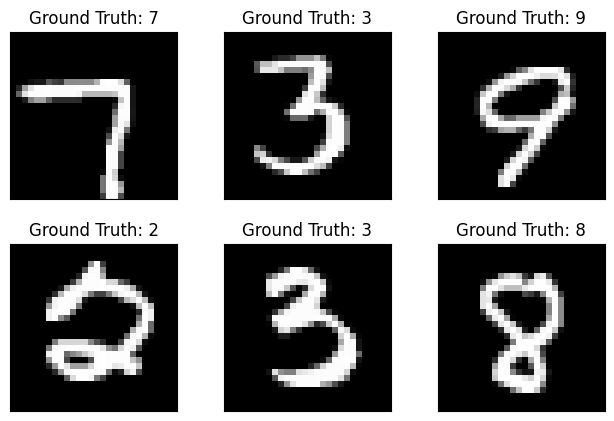

In [ ]:
import matplotlib.pyplot as plt

fig = plt.figure()
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
  plt.title("Ground Truth: {}".format(example_targets[i]))
  plt.xticks([])
  plt.yticks([])

In [16]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# PyTorch model

In [14]:
# Linear regression
class LinearRegression(nn.Module):
    def __init__(self):
        super(LinearRegression, self).__init__()
        self.fc = nn.Linear(28*28, 1)

    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

# Instantiate model and optimizer

In [17]:
linear_model = LinearRegression().to(device)
optimizer = optim.Adam(linear_model.parameters(), lr=learning_rate,amsgrad=True)
classes = torch.tensor([0,1,2,3,4,5,6,7,8,9]).view(1,10).float().to(device)

# Learning algorithm

### Iterare over (a) predict, (b) loss (c) optimize and (d) occasionally look at diagnostics

In [18]:
def train(epoch):
  linear_model.train()
  for batch_idx, (data, target) in enumerate(train_loader):
    data = data.to(device) # X
    target = target.to(device) # y
    optimizer.zero_grad()
    output = linear_model(data) #yp
    loss = F.mse_loss(output, target.float().view_as(output)) # notice the use of view_as
    loss.backward()
    optimizer.step()
    if batch_idx % log_interval == 0:
      print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
        epoch, batch_idx * len(data), len(train_loader.dataset),
        100. * batch_idx / len(train_loader), loss.item()))


In [19]:
def validation():
  linear_model.eval()
  validation_loss = 0
  correct = 0
  with torch.no_grad(): # notice the use of no_grad
    for data, target in validation_loader:
      data = data.to(device)
      target = target.to(device)
      output = linear_model(data)
      validation_loss += F.mse_loss(output, target.float().view_as(output), size_average=False).item()
      _, pred = torch.min(torch.abs(output - classes),dim=1) # notice the type of broadcasting the subtraction uses here
      correct += pred.eq(target.data.view_as(pred)).sum()
  validation_loss /= len(validation_loader.dataset)
  print('\nValidation set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(validation_loss, correct, len(validation_loader.dataset),100. * correct / len(validation_loader.dataset)))

In [20]:
def test():
  linear_model.eval()
  test_loss = 0
  correct = 0
  with torch.no_grad():
    for data, target in test_loader:
      data = data.to(device)
      target = target.to(device)
      output = linear_model(data)
      test_loss += F.mse_loss(output, target.float().view_as(output), size_average=False).item()
      _, pred = torch.min(torch.abs(output - classes),dim=1) # notice the type of broadcasting the subtraction uses here
      correct += pred.eq(target.data.view_as(pred)).sum()
  test_loss /= len(test_loader.dataset)
  print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(test_loss, correct, len(test_loader.dataset),100. * correct / len(test_loader.dataset)))

In [23]:
validation()
for epoch in range(1, n_epochs + 1):
  train(epoch)
  validation()
test()


Validation set: Avg. loss: 7.4069, Accuracy: 813/5000 (16%)

Train Epoch: 1 [0/55000 (0%)]	Loss: 7.412509

Validation set: Avg. loss: 9.3163, Accuracy: 827/5000 (17%)

Train Epoch: 2 [0/55000 (0%)]	Loss: 9.360397

Validation set: Avg. loss: 9.2633, Accuracy: 848/5000 (17%)

Train Epoch: 3 [0/55000 (0%)]	Loss: 9.322331

Validation set: Avg. loss: 7.5206, Accuracy: 851/5000 (17%)

Train Epoch: 4 [0/55000 (0%)]	Loss: 7.567136

Validation set: Avg. loss: 5.7388, Accuracy: 784/5000 (16%)

Train Epoch: 5 [0/55000 (0%)]	Loss: 5.763785

Validation set: Avg. loss: 5.1965, Accuracy: 838/5000 (17%)



KeyboardInterrupt: 

# 3) Multiple Linear Regression — Direct (closed‑form)

**Slides:** Vector/matrix form, ridge regularization, matrix calculus hints.


# Multiple linear Regression for MNIST Images
## This notebook uses closed form solution

In [24]:
import torch
import torchvision

random_seed = 1
torch.backends.cudnn.enabled = False
torch.manual_seed(random_seed)

# Checking GPU availability
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)


cuda:0


# MNIST dataset is part of torchvision
## Divide MNIST into training, validation and test sets
## Use DataLoader iterator for loading data in batches

In [25]:
from torch.utils.data import random_split


MNIST_training = torchvision.datasets.MNIST('/MNIST_dataset/', train=True, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize((0.1307,), (0.3081,))]))

MNIST_test_set = torchvision.datasets.MNIST('/MNIST_dataset/', train=False, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize((0.1307,), (0.3081,))]))

# create a training and a validation set
MNIST_training_set, MNIST_validation_set = random_split(MNIST_training, [55000, 5000])


train_loader = torch.utils.data.DataLoader(MNIST_training_set,batch_size=55000, shuffle=True)

validation_loader = torch.utils.data.DataLoader(MNIST_validation_set,batch_size=5000, shuffle=True)

test_loader = torch.utils.data.DataLoader(MNIST_test_set,batch_size=10000, shuffle=True)

## Check DataLoader

In [26]:
examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)
print(example_data.shape)
print(example_targets.shape)

torch.Size([10000, 1, 28, 28])
torch.Size([10000])


## Also, make sure to display some images

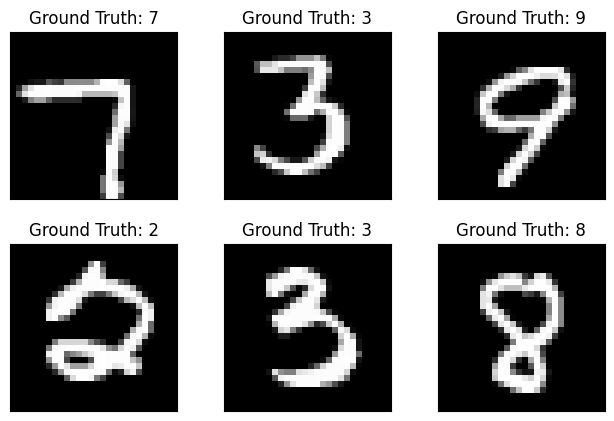

In [27]:
import matplotlib.pyplot as plt

fig = plt.figure()
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
  plt.title("Ground Truth: {}".format(example_targets[i]))
  plt.xticks([])
  plt.yticks([])

## Use closed form solution for $W$, $mean$ and $b$

In [28]:
# We need one hot encoding
one_hot = torch.nn.functional.one_hot

def Estimate_Parameters(train_X,train_y,lam):
  # flatten data
  train_X = train_X.view(train_X.size(0), -1)
  train_y = one_hot(train_y,num_classes=10).float()

  # compute b
  b = torch.mean(train_y,dim=0,keepdim=True)
  # compute mean
  train_X_mean = torch.mean(train_X,dim=0,keepdim=True)
  # compute theta
  X = train_X - train_X_mean
  theta = torch.mm(torch.mm(torch.inverse(torch.matmul(X.t(),X)+lam*torch.eye(784)),X.t()),(train_y-b))

  return theta,train_X_mean,b


## Prediction on validation or test data with leanred model

In [29]:
def Model_Predict(X,theta,data_mean,b): # Notice prediction does not require *lam*
  X = X.view(X.size(0), -1)
  yp = torch.mm(X - data_mean, theta) + b
  return yp

## Accuracy computation

In [30]:
def Compute_Accuracy(yp,y):
  pred = yp.data.max(1, keepdim=True)[1]
  accuracy = (100. * pred.eq(y.data.view_as(pred)).sum()) / y.shape[0]
  return accuracy

## Estimating parameters of the model on training data

In [31]:
def Model_Train(lam):
  train_examples = enumerate(train_loader)
  batch_idx, (train_X, train_y) = next(train_examples)
  theta,data_mean,b = Estimate_Parameters(train_X,train_y,lam)
  return theta,data_mean,b

## Apply model on validation or test and evaluate accuracy

In [32]:
def Model_Evaluate(data_loader,theta,data_mean,b):
  # load  data
  examples = enumerate(data_loader)
  batch_idx, (X, y) = next(examples)

  # compute prediction
  yp = Model_Predict(X,theta,data_mean,b)

  # compute accuracy
  accuracy = Compute_Accuracy(yp,y)
  return accuracy

In [33]:
# Apply linear model on the validation and test sets
lam=0.1
theta,data_mean,b = Model_Train(lam)

validation_accuracy = Model_Evaluate(validation_loader,theta,data_mean,b)
print("Validation set accuracy:", validation_accuracy.item())

test_accuracy = Model_Evaluate(test_loader,theta,data_mean,b)
print("Test set accuracy:", test_accuracy.item())


Validation set accuracy: 84.66000366210938
Test set accuracy: 85.93000030517578


## Using validation set estimate best hyperparameter value

In [34]:
import numpy as np

best_accuracy = 0.0
best_lam = 0.0
for i in torch.range(-1,6,1):
  lam = np.power(10,i)
  theta, data_mean,b = Model_Train(lam)
  validation_accuracy = Model_Evaluate(validation_loader,theta, data_mean,b)
  print("Hyperparameter:",lam.item(),"Validation set accuracy:", validation_accuracy.item())
  if validation_accuracy>best_accuracy:
    best_lam = lam
    best_accuracy = validation_accuracy

# best hyperparameter
print("Best hyperparameter:",best_lam.item())
# estimate model with best hyperparameter value
best_theta, best_data_mean,best_b = Model_Train(best_lam)

# apply best model on test set
test_accuracy = Model_Evaluate(test_loader,best_theta, best_data_mean,best_b)
print("Test set accuracy:", test_accuracy.item())

/tmp/ipython-input-491893306.py:5: UserWarning: torch.range is deprecated and will be removed in a future release because its behavior is inconsistent with Python's range builtin. Instead, use torch.arange, which produces values in [start, end).
  for i in torch.range(-1,6,1):
/tmp/ipython-input-491893306.py:6: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  lam = np.power(10,i)


Hyperparameter: 0.10000000149011612 Validation set accuracy: 84.68000030517578
Hyperparameter: 1.0 Validation set accuracy: 84.66000366210938
Hyperparameter: 10.0 Validation set accuracy: 84.72000122070312
Hyperparameter: 100.0 Validation set accuracy: 84.80000305175781
Hyperparameter: 1000.0 Validation set accuracy: 84.83999633789062
Hyperparameter: 10000.0 Validation set accuracy: 84.9800033569336
Hyperparameter: 100000.0 Validation set accuracy: 84.13999938964844
Hyperparameter: 1000000.0 Validation set accuracy: 79.5
Best hyperparameter: 10000.0
Test set accuracy: 86.55000305175781


In [ ]:
print(best_theta.shape)

torch.Size([784, 10])


## Let's visualize $W$

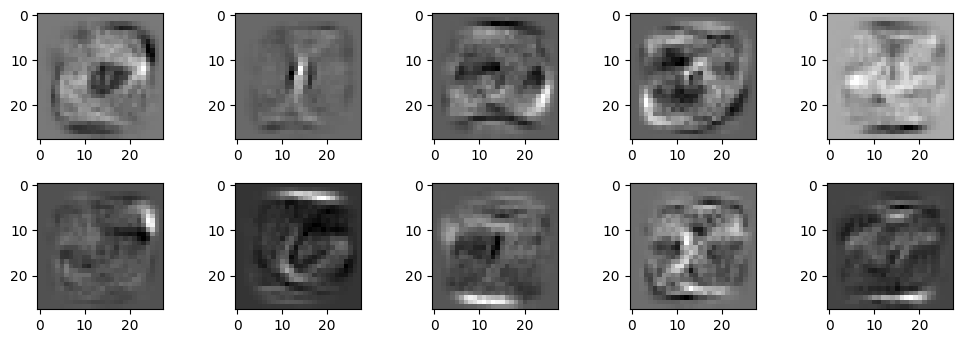

In [35]:
fig = plt.figure(figsize=(10,5))
for i in range(10):
  plt.subplot(3,5,i+1)
  plt.tight_layout()
  plt.imshow(best_theta[:,i].reshape(28,28), cmap='gray', interpolation='none')

# 4) Multiple Linear Regression — PyTorch Optimization

**Slides:** Mini‑batch GD, diagnostics, accuracy.


# Multiple Linear Regression for MNIST Images

In [36]:
import torch
import torchvision
from torch.autograd import Variable

n_epochs = 10
batch_size_train = 200
batch_size_test = 1000
learning_rate = 1e-3
momentum = 0.5
log_interval = 100

random_seed = 1
torch.backends.cudnn.enabled = False
torch.manual_seed(random_seed)

# Checking GPU availability
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)


cuda:0


In [ ]:
N = 3
a = torch.triu_indices(N, N, offset=1)

b = torch.randn(N,N)

print(b)

print(a)

ind = a[1,:] + N*a[0,:]
print(ind)

c = torch.flatten(b)[ind]
print(c)


tensor([[ 0.6614,  0.2669,  0.0617],
        [ 0.6213, -0.4519, -0.1661],
        [-1.5228,  0.3817, -1.0276]])
tensor([[0, 0, 1],
        [1, 2, 2]])
tensor([1, 2, 5])
tensor([ 0.2669,  0.0617, -0.1661])


# MNIST dataset is part of torchvision
## Divide MNIST into training, validation and test sets
## Use DataLoader iterator for loading data in batches

In [44]:
from torch.utils.data import random_split


MNIST_training = torchvision.datasets.MNIST('/MNIST_dataset/', train=True, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize((0.1307,), (0.3081,))]))

MNIST_test_set = torchvision.datasets.MNIST('/MNIST_dataset/', train=False, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize((0.1307,), (0.3081,))]))

# create a training and a validation set
MNIST_training_set, MNIST_validation_set = random_split(MNIST_training, [55000, 5000])


train_loader = torch.utils.data.DataLoader(MNIST_training_set,batch_size=batch_size_train, shuffle=True)

validation_loader = torch.utils.data.DataLoader(MNIST_validation_set,batch_size=batch_size_train, shuffle=True)

test_loader = torch.utils.data.DataLoader(MNIST_test_set,batch_size=batch_size_test, shuffle=True)

## Check DataLoader

In [45]:
examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)
print(example_data.shape)
print(example_targets.shape)

torch.Size([1000, 1, 28, 28])
torch.Size([1000])


## Also, make sure to display some images

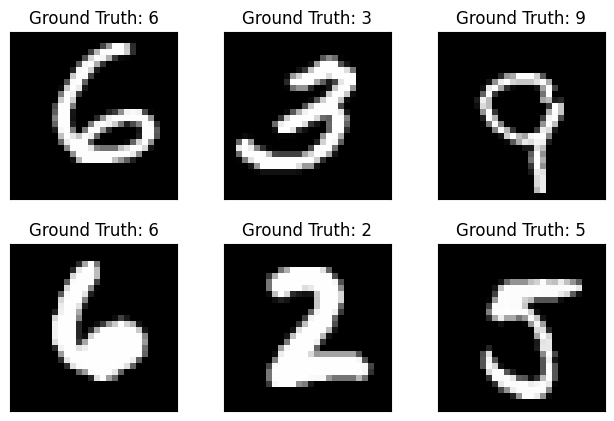

In [46]:
import matplotlib.pyplot as plt

fig = plt.figure()
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
  plt.title("Ground Truth: {}".format(example_targets[i]))
  plt.xticks([])
  plt.yticks([])

In [47]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable

In [48]:
# Multiple Linear regression
class MultipleLinearRegression(nn.Module):
    def __init__(self):
        super(MultipleLinearRegression, self).__init__()
        self.fc = nn.Linear(28*28, 10)

    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

In [49]:
multi_linear_model = MultipleLinearRegression().to(device)
optimizer = optim.Adam(multi_linear_model.parameters(), lr=learning_rate)

one_hot = torch.nn.functional.one_hot


In [50]:
def train(epoch,data_loader,model,optimizer):
  for batch_idx, (data, target) in enumerate(data_loader):
    data = data.to(device)
    target = target.to(device)
    optimizer.zero_grad()
    output = model(data)
    loss = F.mse_loss(output, one_hot(target,num_classes=10).float())
    loss.backward()
    optimizer.step()
    if batch_idx % log_interval == 0:
      print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
        epoch, batch_idx * len(data), len(data_loader.dataset),
        100. * batch_idx / len(data_loader), loss.item()))


In [51]:
def eval(data_loader,model,dataset):
  loss = 0
  correct = 0
  with torch.no_grad(): # notice the use of no_grad
    for data, target in data_loader:
      data = data.to(device)
      target = target.to(device)
      output = model(data)
      pred = output.data.max(1, keepdim=True)[1]
      correct += pred.eq(target.data.view_as(pred)).sum()
      loss += F.mse_loss(output, one_hot(target,num_classes=10).float(), size_average=False).item()
  loss /= len(data_loader.dataset)
  print(dataset+'set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(loss, correct, len(data_loader.dataset), 100. * correct / len(data_loader.dataset)))

In [52]:
eval(validation_loader,multi_linear_model,"Validation")
for epoch in range(1, n_epochs + 1):
  train(epoch,train_loader,multi_linear_model,optimizer)
  eval(validation_loader,multi_linear_model,"Validation")

eval(test_loader,multi_linear_model,"Test")

Validationset: Avg. loss: 3.6766, Accuracy: 520/5000 (10%)

Train Epoch: 1 [0/55000 (0%)]	Loss: 0.376203
Train Epoch: 1 [20000/55000 (36%)]	Loss: 0.055781
Train Epoch: 1 [40000/55000 (73%)]	Loss: 0.046230
Validationset: Avg. loss: 0.4471, Accuracy: 4177/5000 (84%)

Train Epoch: 2 [0/55000 (0%)]	Loss: 0.044631
Train Epoch: 2 [20000/55000 (36%)]	Loss: 0.040951
Train Epoch: 2 [40000/55000 (73%)]	Loss: 0.041303
Validationset: Avg. loss: 0.4177, Accuracy: 4181/5000 (84%)

Train Epoch: 3 [0/55000 (0%)]	Loss: 0.040528
Train Epoch: 3 [20000/55000 (36%)]	Loss: 0.038015
Train Epoch: 3 [40000/55000 (73%)]	Loss: 0.041736
Validationset: Avg. loss: 0.4117, Accuracy: 4245/5000 (85%)

Train Epoch: 4 [0/55000 (0%)]	Loss: 0.040020
Train Epoch: 4 [20000/55000 (36%)]	Loss: 0.044309
Train Epoch: 4 [40000/55000 (73%)]	Loss: 0.037800
Validationset: Avg. loss: 0.4060, Accuracy: 4202/5000 (84%)

Train Epoch: 5 [0/55000 (0%)]	Loss: 0.038979
Train Epoch: 5 [20000/55000 (36%)]	Loss: 0.038213
Train Epoch: 5 [40000

In [ ]:
for param in multi_linear_model.parameters():
    print(param)

Parameter containing:
tensor([[-0.0107,  0.0197, -0.0277,  ..., -0.0052, -0.0034, -0.0133],
        [ 0.0009, -0.0241, -0.0221,  ..., -0.0066,  0.0137,  0.0303],
        [-0.0359,  0.0239,  0.0144,  ..., -0.0151, -0.0240,  0.0279],
        ...,
        [-0.0140,  0.0250,  0.0249,  ...,  0.0216,  0.0003, -0.0231],
        [ 0.0229, -0.0226,  0.0327,  ..., -0.0096, -0.0102,  0.0260],
        [-0.0081, -0.0053, -0.0356,  ..., -0.0372,  0.0288,  0.0193]],
       device='cuda:0', requires_grad=True)
Parameter containing:
tensor([-0.0161,  0.0225,  0.0036,  0.0039,  0.0106,  0.0302,  0.0360,  0.0310,
         0.0090,  0.0271], device='cuda:0', requires_grad=True)


# Gradient Descent Without Using PyTorch Autograd or Optimizer

In [54]:
def myGD_train(epoch,data_loader,model,learning_rate):
  for batch_idx, (data, target) in enumerate(data_loader):
    data = data.to(device)
    target = target.to(device)
    output = model(data)
    one_hot_target = one_hot(target,num_classes=10).float()
    loss = F.mse_loss(output, one_hot_target)

    with torch.no_grad():
        W = list(model.parameters())[0]
        b = list(model.parameters())[1]
        X = data.view(data.size(0), -1)
        gradW = torch.mm(torch.mm(X.T,X),W.T) - torch.mm(X.T,one_hot_target)
        gradW = gradW.T
        W.copy_(W - learning_rate*gradW)
        gradb = torch.sum(output - one_hot_target,dim=0)
        b.copy_(b - learning_rate*gradb)

    if batch_idx % log_interval == 0:
      print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
        epoch, batch_idx * len(data), len(data_loader.dataset),
        100. * batch_idx / len(data_loader), loss.item()))

In [55]:
multi_linear_model = MultipleLinearRegression().to(device)

eval(validation_loader,multi_linear_model,"Validation")
for epoch in range(1, n_epochs + 1):
  myGD_train(epoch,train_loader,multi_linear_model,0.00001)
  eval(validation_loader,multi_linear_model,"Validation")

eval(test_loader,multi_linear_model,"Test")

Validationset: Avg. loss: 3.8418, Accuracy: 372/5000 (7%)

Train Epoch: 1 [0/55000 (0%)]	Loss: 0.370418
Train Epoch: 1 [20000/55000 (36%)]	Loss: 0.092870
Train Epoch: 1 [40000/55000 (73%)]	Loss: 0.066480
Validationset: Avg. loss: 0.6501, Accuracy: 3708/5000 (74%)

Train Epoch: 2 [0/55000 (0%)]	Loss: 0.065549
Train Epoch: 2 [20000/55000 (36%)]	Loss: 0.062701
Train Epoch: 2 [40000/55000 (73%)]	Loss: 0.061697
Validationset: Avg. loss: 0.5556, Accuracy: 3909/5000 (78%)

Train Epoch: 3 [0/55000 (0%)]	Loss: 0.059994
Train Epoch: 3 [20000/55000 (36%)]	Loss: 0.056801
Train Epoch: 3 [40000/55000 (73%)]	Loss: 0.052625
Validationset: Avg. loss: 0.5144, Accuracy: 4028/5000 (81%)

Train Epoch: 4 [0/55000 (0%)]	Loss: 0.050779
Train Epoch: 4 [20000/55000 (36%)]	Loss: 0.048551
Train Epoch: 4 [40000/55000 (73%)]	Loss: 0.050628
Validationset: Avg. loss: 0.4889, Accuracy: 4116/5000 (82%)

Train Epoch: 5 [0/55000 (0%)]	Loss: 0.052329
Train Epoch: 5 [20000/55000 (36%)]	Loss: 0.047088
Train Epoch: 5 [40000/

---
## 🧩 Stretch Exercises — Logistic Regression (Softmax)

**Slides:** “Logistic Regression” → softmax probabilities and cross‑entropy loss.

1. Implement a linear → softmax classifier with `nn.Linear(784, 10)` + `nn.CrossEntropyLoss()`.
2. Train for a few epochs with SGD/Adam and report accuracy.
3. Compare training curves vs multiple linear regression (scores vs probabilities).

> Starter scaffold below.

In [ ]:
# TODO: Implement Logistic Regression (Softmax) — Starter scaffold

class SoftmaxClassifier(nn.Module):
    def __init__(self, in_dim=28*28, n_classes=10):
        super().__init__()
        self.fc = nn.Linear(in_dim, n_classes)
    def forward(self, x):
        x = x.view(x.size(0), -1)
        return self.fc(x)

model = SoftmaxClassifier().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.1)

def train_epoch(model, loader):
    model.train()
    total, correct, loss_sum = 0, 0, 0.0
    for x, y in loader:
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        logits = model(x)
        loss = criterion(logits, y)
        loss.backward()
        optimizer.step()

        loss_sum += loss.item() * x.size(0)
        pred = logits.argmax(dim=1)
        correct += (pred == y).sum().item()
        total += x.size(0)
    return loss_sum/total, correct/total

def eval_epoch(model, loader):
    model.eval()
    total, correct, loss_sum = 0, 0, 0.0
    with torch.no_grad():
        for x, y in loader:
            x, y = x.to(device), y.to(device)
            logits = model(x)
            loss = criterion(logits, y)
            loss_sum += loss.item() * x.size(0)
            pred = logits.argmax(dim=1)
            correct += (pred == y).sum().item()
            total += x.size(0)
    return loss_sum/total, correct/total

for epoch in range(5):
    tr_loss, tr_acc = train_epoch(model, train_loader)
    te_loss, te_acc = eval_epoch(model, test_loader)
    print(f"Epoch {epoch+1}: train loss {tr_loss:.4f}, acc {tr_acc:.4f} | test loss {te_loss:.4f}, acc {te_acc:.4f}")

Epoch 1: train loss 0.3947, acc 0.8850 | test loss 0.3114, acc 0.9102
Epoch 2: train loss 0.3059, acc 0.9127 | test loss 0.2890, acc 0.9164
Epoch 3: train loss 0.2916, acc 0.9175 | test loss 0.2864, acc 0.9170
Epoch 4: train loss 0.2835, acc 0.9203 | test loss 0.2801, acc 0.9199
Epoch 5: train loss 0.2785, acc 0.9223 | test loss 0.2792, acc 0.9221
